### 2. CNNs en Google Street View

En esta sección, trabajaremos con el dataset SVHN (Street View House Numbers), correspondiente a imágenes naturales de dígitos de direcciones obtenidos desde Google Street View, sobre el cual se analizarán los beneficios de diferentes métodos convolucionales y de pooling. Se hace uso de las siguientes librerías:

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.io as sio
import h5py

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.models import load_model
from keras import backend as K

*** a)*** Inicialmente se cargan los datos y se determina el tamaño de las imágenes, el número de clases diferentes y de ejemplos en cada categoría. A grandes rasgos se tiene un dataset con imágenes RGB de tamaño 32 x 32, dividido en un conjunto de entrenamiento (73257 ejemplos) y otro de prueba (26032 ejemplos), y etiquetado dentro de diez clases (una por cada dígito).

In [33]:
train_data = sio.loadmat('../train_32x32.mat')
test_data = sio.loadmat('../test_32x32.mat')

# Cargar set de entrenamiento
X_train = train_data['X'].T
y_train = train_data['y'] - 1

# Cargar set de test
X_test = test_data['X'].T
y_test = test_data['y'] - 1

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Número de clases
n_classes = len(np.unique(y_train))

# Número de ejemplos
n_train = len(X_train)
n_test = len(X_test)

print ("Tamaño imágenes: " , np.shape(X_train[0])[1], "x", np.shape(X_train[0])[2])
print ("Número de clases:" , n_classes)

print ("\nNumero de ejemplos de entrenamiento por categoria:")
for i in np.unique(y_train):
    print ("Categoría",str(i), ":", str(np.where(y_train==i)[0].shape[0]), "ejemplos")
print ("Total ejemplos de entrenamiento:" , n_train)

print ("\nNumero de ejemplos de prueba por categoria:")
for i in np.unique(y_test):
    print ("Categoría",str(i), ":", str(np.where(y_test==i)[0].shape[0]), "ejemplos")
print ("Total ejemplos de test:" , n_test)

Tamaño imágenes:  32 x 32
Número de clases: 10

Numero de ejemplos de entrenamiento por categoria:
Categoría 0 : 13861 ejemplos
Categoría 1 : 10585 ejemplos
Categoría 2 : 8497 ejemplos
Categoría 3 : 7458 ejemplos
Categoría 4 : 6882 ejemplos
Categoría 5 : 5727 ejemplos
Categoría 6 : 5595 ejemplos
Categoría 7 : 5045 ejemplos
Categoría 8 : 4659 ejemplos
Categoría 9 : 4948 ejemplos
Total ejemplos de entrenamiento: 73257

Numero de ejemplos de prueba por categoria:
Categoría 0 : 5099 ejemplos
Categoría 1 : 4149 ejemplos
Categoría 2 : 2882 ejemplos
Categoría 3 : 2523 ejemplos
Categoría 4 : 2384 ejemplos
Categoría 5 : 1977 ejemplos
Categoría 6 : 2019 ejemplos
Categoría 7 : 1660 ejemplos
Categoría 8 : 1595 ejemplos
Categoría 9 : 1744 ejemplos
Total ejemplos de test: 26032


Luego, se visualizan 5 imágenes de entrenamiento y 5 de prueba elegidas aleatoriamente:

Set de Entrenamiento:


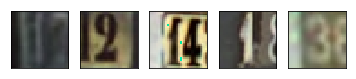

Set de Test:


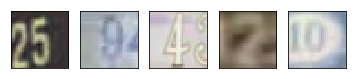

In [2]:
# Número de imágenes a mostrar
n_im = 5

print ("Set de Entrenamiento:")

# Se eligen n elementos al azar
index = random.sample(list(X_train), n_im)

for i in range(0,len(index)):      
    ax = plt.subplot(2, n_im, 1+i)
    im = index[i].reshape(3,32,32).transpose(2,1,0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
        
plt.show()

print ("Set de Test:")

# Se eligen n elementos al azar
index = random.sample(list(X_test), 5)

for i in range(0,len(index)):      
    ax = plt.subplot(1, n_im, 1+i)
    im = index[i].reshape(3,32,32).transpose(2,1,0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    
plt.show()

Se presentan diez muestras aleatorias de la tarea de clasificación del dataset SVHN, cada una de las cuales es asignada a una etiqueta de un único dígito, correspondiente al dígito central de la imagen. Así, el hecho de que cada input pueda presentar dígitos secundarios dificulta la tarea, motivando aún más los potenciales buenos resultados que una red convolucional podría lograr. Esto último, sumado a las dificultades intrínsecas de cualquier tarea de reconocimiento de carácteres en contextos naturales (todas ellas presentes en el dataset) como fondos no contrastantes, baja resolución, desenfoque y/o considerables diferencias de iluminación, entregan resultados donde el mejor método computacional actual de clasificación sobre SVHN no logra superar el desempeño del humano (98.0%).

*** b)*** A continuación, se normalizan las imágenes dividiendo las intensidades originales de pixel por 255, mapeándolas al intervalo [0,1]. Además se modifica la representación de la salida a un vector binario con representación 'one hot encoding'.

In [34]:
X_train /= 255.0
X_test /= 255.0

Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

***c)*** Se define una CNN con arquitectura _C x P x C x P x F x F_. Para la primera capa convolucional se utilizan 16 filtros de 5 x 5 y para la segunda 512 filtros de 7 x 7. Para la capa MLP escondida se usan 20 neuronas. Cabe destacar que esta arquitectura, con algunas diferencias, fue una de las primera CNNs entrenadas sobre SVHN consiguiendo una accuracy de 94.28%.

In [4]:
(n_channels, n_rows, n_cols) = np.shape(X_train[0])

model = Sequential()
model.add(Convolution2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, (7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 32, 32)        1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 16, 16)       401920    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 512, 8, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total para

A partir de este esquema es posible visualizar los cambios de dimensiones que experimenta un patrón de entrada a medida que se ejecuta un forward-pass. En términos generales, se observa que las capas convolucionales únicamente varian la cantidad de filtros con que el input es procesado. En cambio son las capas de pooling (método 'MaxPooling') quienes efectivamente reducen la dimensión del patrón de entrada, en particular cada imagen de entrada de tamaño 32 x 32 se reduce a 16 x 16 y a 8 x 8 luego de pasar por la primera y la segunda capa de pooling respectivamente (ambas de filtros tamaño 2 x 2). A continuación, se prepara la representación para entregársela a la capa MLP de 20 neuronas, por medio de una operación flatten que arroja un arreglo unidimensional de largo 512 x 8 x 8 = 32768. Finalmente, la capa de salida es representada por 10 neuronas (una por cada clase) encargadas de arrojar la clasificación resultante de la red.

In [5]:
model.compile(loss='binary_crossentropy', optimizer="adagrad", metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test))

Train on 73257 samples, validate on 26032 samples
Epoch 1/10
73257/73257 [==============================] - 517s - loss: 0.2681 - acc: 0.9126 - val_loss: 0.2033 - val_acc: 0.9332
Epoch 2/10
73257/73257 [==============================] - 416s - loss: 0.1745 - acc: 0.9405 - val_loss: 0.1568 - val_acc: 0.9466
Epoch 3/10
73257/73257 [==============================] - 416s - loss: 0.1338 - acc: 0.9528 - val_loss: 0.1391 - val_acc: 0.9512
Epoch 4/10
73257/73257 [==============================] - 417s - loss: 0.1112 - acc: 0.9625 - val_loss: 0.1251 - val_acc: 0.9584
Epoch 5/10
73257/73257 [==============================] - 416s - loss: 0.0997 - acc: 0.9669 - val_loss: 0.1127 - val_acc: 0.9629
Epoch 6/10
73257/73257 [==============================] - 416s - loss: 0.0921 - acc: 0.9696 - val_loss: 0.1078 - val_acc: 0.9646
Epoch 7/10
73257/73257 [==============================] - 416s - loss: 0.0865 - acc: 0.9714 - val_loss: 0.1053 - val_acc: 0.9659
Epoch 8/10
73257/73257 [=======================

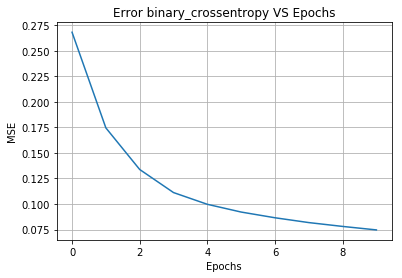

In [6]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error binary_crossentropy VS Epochs")
plt.plot(hist.epoch, hist.history['loss'])
plt.grid(True)

plt.show()

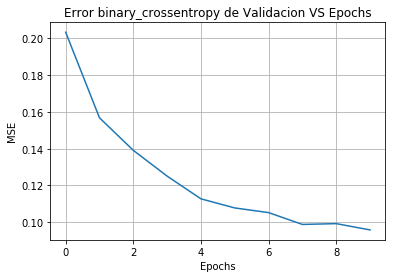

In [7]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error binary_crossentropy de Validacion VS Epochs")
plt.plot(hist.epoch, hist.history['val_loss'])
plt.grid(True)

plt.show()

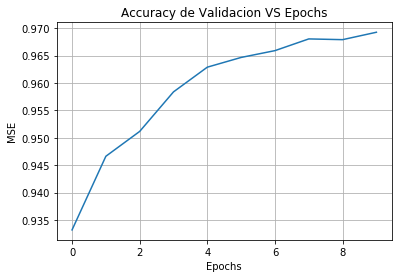

In [8]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist.epoch, hist.history['val_acc'])
plt.grid(True)

plt.show()

Luego se consigue un accuracy bastante elevado luego de tan solo 10 epochs: 0.9692. Así, se logra incluso superar el resultado reportado en la literatura. Si bien, esto pudo producirse por decisiones positivas del entrenamiento (como utilizar "adagrad" para el proceso de optimización), muy posiblemente se deba por una función de pérdida no adecuada para el problema. Así, tal accuracy pudo haber sido calculado considerando un carácter independiente en las salidas, lo cual no se adapta con las condiciones excluyentes de la salida presente.

***d)*** Ahora, se evalúa el efecto de modificar el tamaño de los filtros (de convolución y pooling) reportando la
sensibilidad del error de pruebas a estos cambios. Por simplicidad se entrena durante sólo 10 epochs. Además se asumen ambas capas de convolucionales y de pooling de igual estructura.

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D

(n_channels, n_rows, n_cols) = np.shape(X_train[0])

def generate_model(cf_size, cp_size):
    model = Sequential()
    model.add(Convolution2D(16,(cf_size,cf_size), padding='same',activation='relu',input_shape=(n_channels, n_rows, n_cols)))
    model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
    model.add(Convolution2D(512,(cf_size,cf_size), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    return model

# Tamaño capas convolucionales
cf_size = [3,5,7,9]
# Tamaño capas de pooling
cp_size = [2,4]

for i in cf_size:
    for j in cp_size:
        model = generate_model(i,j)
        #print "Modelo con tamaño capa convolucional: ", i, " y tamaño capa de pooling: ", j
        #model.summary()

Para el entrenamiento de los modelos (realizado en GPU):

In [ ]:
# Tamaño capas convolucionales
cf_size = [3,5,7,9]
# Tamaño capas de pooling
cp_size = [2,4]

for i in cf_size:
    for j in cp_size:            
        print ("Modelo con tamaño capa convolucional: ", i, " y tamaño capa de pooling: ", j)
        model = generate_model(i,j)
        model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
        model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test))
        model.save('entrenamientos/3d-'+str(i)+'-'+str(j)+'-neuronas.h5')

Luego, se resumen los resultados obtenidos en la siguiente tabla:

|Tamaño Capa Convolucional|Tamaño Capa de Pooling|loss|accuracy|Tiempo epoch[s]|
|:--------------:|:------------:|:--:|:--:|:--:|
|3|2|0.1270|0.9553|23|
|3|4|0.2107|0.9247|18|
|5|2|0.2075|0.9263|29|
|5|4|0.2194|0.9199|26|
|7|2|2.9574|0.8155|43|
|7|4|0.1893|0.9310|40|
|9|2|2.5781|0.8392|57|
|9|4|0.1894|0.9312|55|

Se observa que para casos con tamaño de capa convolucional es 3 o 5, los mejores resultados se obtienen con tamaño de capa de pooling 2. Por otro lado, cuando el tamaño de capa convolucional es 7 o 9, el tamaño de capa de pooling 4 obtiene resultados considerablemente mejores. Se observa además que el accuracy más competitivo es el alcanzado cuando el tamaño de capa convolucional es 3 y capa de pooling 2, con un accuracy de 95,53%. En cambio, la función de pérdida se minimiza en 0.1184 al considerar capa convolucional con filtros de tamaño 7 y capa de pooling con filtros tamaño 4.

En cuanto a los tiempos de entrenamiento, el patrón resulta más intuitivo: al aumentar el tamaño de la capa de pooling se disminuye el tiempo de entrenamiento debido a la reducción de dimensionalidad, pero al aumentar el tamaño de la capa convolucional, el tiempo de entrenamiento también lo hace, dado el incremento del tamaño de los canales que efectúa la salida.

*** e) *** Luego, se evalúa el efecto de modificar el tamaño de los filtros (de convolución y pooling) reportando la
sensibilidad del error de pruebas a estos cambios. Por simplicidad se entrena durante sólo 10 epochs. Además se asumen ambas capas de convolucionales y de pooling de igual estructura. Se utilizan filtos de tamaño 3 x 3 y 2 x 2 para el proceso convolucional y de pooling respectivamente.

In [ ]:
def generate_model_f(n_filters_l1, n_filters_l2):
    
    (n_channels, n_rows, n_cols) = np.shape(X_train[0])

    # Se eligen estos parámetros
    cf_size = 3
    cp_size = 2
    
    model = Sequential()
    model.add(Convolution2D(n_filters_l1,cf_size,cf_size,border_mode='same',activation='relu',
    input_shape=(n_channels, n_rows, n_cols)))
    model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
    model.add(Convolution2D(n_filters_l2,cf_size,cf_size,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    return model

In [ ]:
#nuevo
n_filters_l1_array = [16,32,64,128]
n_filters_l2_array = [32,64,128,256]

for i in n_filters_l1_array:
    for j in n_filters_l2_array:
        print "Modelo con #filtros capa 1: ", i, " y #filtros capa 2: ", j
        model = generate_model_f(i,j)
        model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
        model.fit(X_train, Y_train, batch_size=1280, nb_epoch=10, verbose=1, validation_data=(X_test, Y_test))

Luego, se resumen los resultados obtenidos en la siguiente tabla:

|Filtros Capa 1|Filtros Capa 2|loss|accuracy|Tiempo epoch [s]|
|:--------------:|:------------:|:------------:|:----------:|:--:|
|16|32|0.1243|0.9573|17|
|16|64|0.1203|0.9583|21|
|16|128|2.5781|0.8392|21|
|16|256|0.1371|0.9510|24|
|32|32|0.1317|0.9541|28|
|32|64|0.2203|0.9241|24|
|32|128|0.2136|0.9209|25|
|32|256|0.1068|0.9646|28|
|64|32|0.1435|0.9488|32|
|64|64|0.1307|0.9528|34|
|64|128|0.1978|0.9303|37|
|64|256|0.1443|0.9490|48|
|128|32|0.1429|0.9502|41|
|128|64|0.1193|0.9583|44|
|128|128|0.3180|0.9000|52|
|128|256|0.2119|0.9271|75|

Nuevamente el tiempo de entrenamiento resultante parece intuitivo: aumenta con la cantidad de filtros procesados, ya sea de la capa 1 o la 2. Por otro lado, no es posible observar una tendencia clara respecto al número de filtros y el accuracy o loss de la red. Sin embargo, el mejor resultado es el de 32 filtros en la capa 1 y 256 filtros en la capa 2 con un accuracy de 96,46%. Notar que dicho resultado tiene sentido al considerar que el aumento de filtros para la segunda capa implicaría un balance de dimensionalidad acertivo dados los efectos contrarios producidos por ambas capas de pooling.

***f)*** Luego, se propone una mejora sobre la red definida en c) que mejore el error de pruebas. Así, se decide imitar la estructura sugerida en 1.e), donde se aplica una doble capa convolucional entre cada capa de pooling, esto es una arquitectura del tipo C x C x P x C x C x P X F x F. Además se considera un decay de 0.000001 y un momentum de 0.9 con el fin de repeler el riesgo de overfitting dado el considerable aumento de profundidad en la estructura de la red. Notar que el resto del motaje es equivalente a aquel con mejor resultado momentaneo.

In [ ]:
model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',activation='relu',input_shape=(3,32,32)))
model.add(Convolution2D(32, 3, 3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [ ]:
# Se corre en el servidor con GPU
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
batch_size = 1280
n_epoch = 20
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))

In [2]:
# Se carga el output obtenido para mostrarlo
text_file = open('output_2f', 'r')
output = text_file.read()
print (output)

Train on 73257 samples, validate on 26032 samples
Epoch 1/20

73257/73257 [==============================] - 74s - loss: 0.3191 - acc: 0.9000 - val_loss: 0.3166 - val_acc: 0.9000
Epoch 2/20

73257/73257 [==============================] - 75s - loss: 0.3175 - acc: 0.9000 - val_loss: 0.3158 - val_acc: 0.9000
Epoch 3/20

73257/73257 [==============================] - 75s - loss: 0.3166 - acc: 0.9000 - val_loss: 0.3142 - val_acc: 0.9000
Epoch 4/20

73257/73257 [==============================] - 75s - loss: 0.3139 - acc: 0.9003 - val_loss: 0.3099 - val_acc: 0.9008
Epoch 5/20

73257/73257 [==============================] - 75s - loss: 0.3019 - acc: 0.9029 - val_loss: 0.2837 - val_acc: 0.9055
Epoch 6/20

73257/73257 [==============================] - 75s - loss: 0.2562 - acc: 0.9145 - val_loss: 0.2140 - val_acc: 0.9235
Epoch 7/20

73257/73257 [==============================] - 75s - loss: 0.2021 - acc: 0.9296 - val_loss: 0.2549 - val_acc: 0.9081
Epoch 8/20

73257/73257 [======================

Luego, el modelo propuesto, efectivamente mejora bastante los resultados comparado acon los modelos similares vistos hasta ahora, obteniendo un accuracy de 97,56%  y un loss de 0.0773.

***g)*** Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos
correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro
sobre algunas imágenes de entrenamiento. Comente.

In [4]:
selectModel= load_model('entrenamientos/3d-5-4-neuronas.h5') #5x4
selectModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 32, 32)        1216      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 8, 8)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 512, 8, 8)         205312    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 512, 2, 2)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                40980     
_________________________________________________________________
dense_22 (Dense)             (None, 10)                210       
Total para

Para la muestro de pesos por filtros:

In [18]:
layers = selectModel.layers
capa1 = layers[0] #se define primera capa
pesos1= np.array(capa1.get_weights())

print ('Pesos Primera Capa Convolucional')
print (capa1.get_config())
print (pesos1[0].shape)
print (pesos1[0])

Pesos Primera Capa Convolucional
{'name': 'conv2d_21', 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'mode': 'fan_avg', 'seed': None, 'scale': 1.0, 'distribution': 'uniform'}}, 'kernel_constraint': None, 'batch_input_shape': (None, 3, 32, 32), 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'padding': 'same', 'kernel_size': (5, 5), 'strides': (1, 1), 'dtype': 'float32', 'activity_regularizer': None, 'kernel_regularizer': None, 'use_bias': True, 'activation': 'relu', 'bias_regularizer': None, 'bias_constraint': None, 'filters': 16, 'data_format': 'channels_first', 'dilation_rate': (1, 1), 'trainable': True}
(5, 5, 3, 16)
[[[[ -9.75923464e-02   4.77411821e-02   1.01810828e-01 ...,
      7.51539366e-03  -7.26575404e-02  -1.20637946e-01]
   [ -3.41341011e-02  -1.08899370e-01  -4.10671905e-02 ...,
      6.22195601e-02  -1.17263809e-01  -1.09118097e-01]
   [ -1.01508096e-01   6.46763369e-02  -6.94949999e-02 ...,
      9.50330198e-02  -1.50042668e-01  -2.240035

Y para su respectiva visualización:

In [19]:
def resize_img(im):
    a = np.zeros((32,32,3))
    for rgb in range(len(im)):
        for i in range(len(im[rgb])):
            for j in range(len(im[rgb][i])):
                a[j][i][rgb] = im[rgb][i][j]
    return a

Imagen a visualizar:


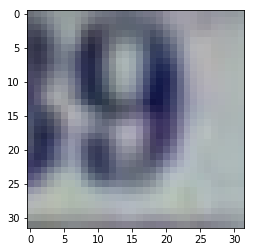

In [44]:
img = random.choice(X_test)
print ('Imagen a visualizar:')
plt.figure()
plt.imshow(resize_img(img))
plt.show()
plt.close()

In [45]:
get_1st_layer_output = K.function([selectModel.layers[0].input],[selectModel.layers[0].output])
layer_output = get_1st_layer_output([np.array([img])])[0]

Filtros:


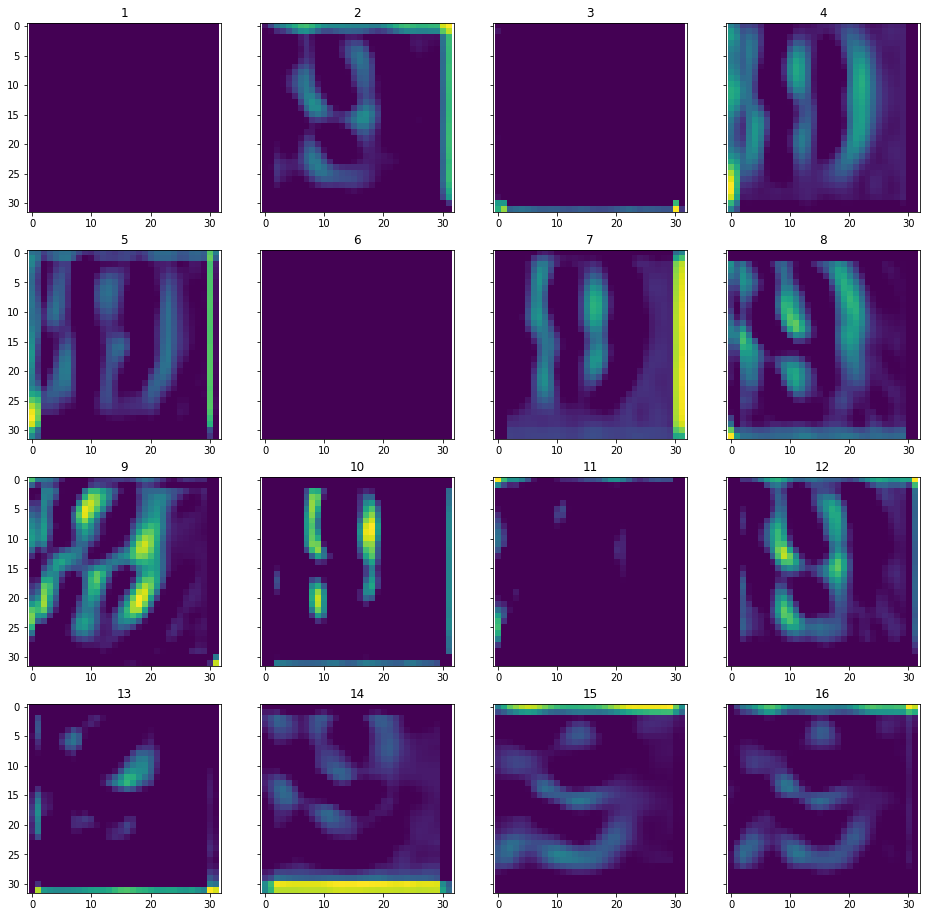

In [46]:
filters = layer_output[0]
print( "Filtros:")
f, ax = plt.subplots(4, 4, sharey=True, figsize=(16,16))
for i in range(4):
    for j in range(4):
        nf = 4*(i) + j + 1
        ax[i][j].set_title(nf)
        ax[i][j].imshow(np.transpose(filters[nf-1]))
        
plt.show()
plt.close()

En las imágenes anteriores se puede obsevar claramente ve cada filtro la imágen que entra a la primera capa de la red neuronal. Cada filtro observa una característica diferente, por ejemplo, uno puede observar bordes, otro textura y otro colores, sin embargo, estos son solo un ejemplo, puesto a que no sabemos que característica especifica ve cada filtro. Se destaca este procedimiento como una forma de transparentizar el proceso de aprendizaje de la red, lo cual resulta útil para aplicaciones en que es necesario entender como las predicciones están siendo efectuadas.

*** h)*** Se elige una de las redes entrenadas en esta sección y determine los pares de dı́gitos (por ejemplo “1” con
“7”) que la red tiende a confundir.

In [30]:
selectModel= load_model('entrenamientos/3d-5-4-neuronas.h5') #5x4

Procediendo de manera similar a la sección 1.h):

In [36]:
def subcategory(x,y,categoria):
    seleccionados=[]
    subArray=[]
    for i in range(len(y)):
        if y[i] == categoria:
            seleccionados.append(i)
    for j in seleccionados:
        subArray.append(x[j])
    return np.array(subArray) 

cero = subcategory(X_test, y_test, 0)
uno = subcategory(X_test, y_test, 1)
dos = subcategory(X_test, y_test, 2)
tres = subcategory(X_test, y_test, 3)
cuatro = subcategory(X_test, y_test, 4)
cinco = subcategory(X_test, y_test, 5)
seis = subcategory(X_test, y_test, 6)
siete = subcategory(X_test, y_test, 7)
ocho = subcategory(X_test, y_test, 8)
nueve = subcategory(X_test, y_test, 9)

In [37]:
print('Prediciendo por categorias:')
predcero = selectModel.predict(cero, verbose=1)
preduno = selectModel.predict(uno, verbose=1)
preddos = selectModel.predict(dos, verbose=1)
predtres = selectModel.predict(tres, verbose=1)
predcuatro = selectModel.predict(cuatro, verbose=1)
predcinco = selectModel.predict(cinco, verbose=1)
predseis = selectModel.predict(seis, verbose=1)
predsiete = selectModel.predict(siete, verbose=1)
predocho = selectModel.predict(ocho, verbose=1)
prednueve = selectModel.predict(nueve, verbose=1)

Prediciendo por categorias:
1696/1744 [============================>.] - ETA: 0s

In [38]:
def catDePrediccion(prediction):
    a= np.argmax(prediction, axis=1)
    unique, counts = np.unique(a, return_counts=True)
    result= dict(zip(unique, counts))
    orden=sorted(result.values())
    one= None
    two = None
    for key, value in result.items():
        if value == orden[-1]:
            one = key
        elif value == orden[-2]:
            two = key
    return one, two

In [42]:
clases=['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']
a, b = catDePrediccion(predcero)
print("Para cero la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(preduno)
print("Para uno la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(preddos)
print("Para dos la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predtres)
print("Para tres la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predcuatro)
print("Para cuatro la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predcinco)
print("Para cinco la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predseis)
print("Para seis la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predsiete)
print("Para siete la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predocho)
print("Para ocho la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(prednueve)
print("Para nueve la predicciones tienden a: ",clases[a]," y " ,clases[b])


Para cero la predicciones tienden a:  cero  y  seis
Para uno la predicciones tienden a:  uno  y  dos
Para dos la predicciones tienden a:  dos  y  cuatro
Para tres la predicciones tienden a:  tres  y  cero
Para cuatro la predicciones tienden a:  cuatro  y  dos
Para cinco la predicciones tienden a:  cinco  y  cuatro
Para seis la predicciones tienden a:  seis  y  cero
Para siete la predicciones tienden a:  siete  y  cinco
Para ocho la predicciones tienden a:  ocho  y  uno
Para nueve la predicciones tienden a:  nueve  y  ocho


Como se ve en lo anterior existen clases en donde se confunden las imágenes de la red neuronal. Si observan los resultados los valores mas repetidos en la confusión son los mas bajos (cero, uno, dos), esto es debido a que en el conjunto de entrenamiento, estos ejemplares poseen más instancias (dataset no perfectamente balanceado), por consecuencia la red entrenada tiende a preferir estas imágenes por sobre el resto. Sin embargo existen conjeturas obvias, que son interpretadas como confusiones genuinas de la red, como por ejemplo, nueve con ocho y seis con cero, ya que estos presentan estructuras circulares bastante similares.